In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from scipy.integrate import cumulative_trapezoid
from ad99 import AlexanderDunkerton1999
from constants import GRAV,R_DRY,C_P

## Load Loon Data

In [2]:
from glob import iglob 
import os
LOON_GW_DATA_PATH = '/Users/robcking/PhD/loon_GW_mom_flux'
u_flux_ptv = []
u_flux_ntv = []
for f in iglob(os.path.join(LOON_GW_DATA_PATH,'*flux.npy')):
    flux = np.load(f)
    u_flux_ntv.append(flux[0])
    u_flux_ptv.append(flux[1])
    v_flux_ntv = flux[2]    
    v_flux_ptv = flux[3]

In [3]:
loon_ntv_u = np.concatenate(u_flux_ntv)
loon_ptv_u = np.concatenate(u_flux_ptv)
loon_abs_u = np.concatenate([np.abs(loon_ntv_u),np.abs(loon_ptv_u)])

## Load MiMA sim data + Loon masks

In [4]:
## Load in MiMA data
ds = xr.open_dataset('data/atmos_daily_omega.nc')


In [5]:
ds_mask_trop = xr.open_dataset('data/loon_masks.nc')

ds_mask_trop['lon'] = (ds_mask_trop.lon + 360) % 360 
ds_mask_trop = ds_mask_trop.sortby('lon')

interp_mask = ds_mask_trop.interp(lat=ds.lat,lon=ds.lon,method='nearest').astype(bool)
interp_mask ## Masks

<xarray.Dataset> Size: 50kB
Dimensions:                 (lat: 64, lon: 128)
Coordinates:
  * lat                     (lat) float32 256B -87.86 -85.1 ... 85.1 87.86
  * lon                     (lon) float32 512B 0.0 2.812 5.625 ... 354.4 357.2
Data variables:
    tropical_atlantic       (lat, lon) bool 8kB False False ... False False
    extratropical_atlantic  (lat, lon) bool 8kB False False ... False False
    extratropical_pacific   (lat, lon) bool 8kB False False ... False False
    indian                  (lat, lon) bool 8kB False False ... False False
    tropical_pacific        (lat, lon) bool 8kB False False ... False False
    southern_ocean          (lat, lon) bool 8kB False False ... False False

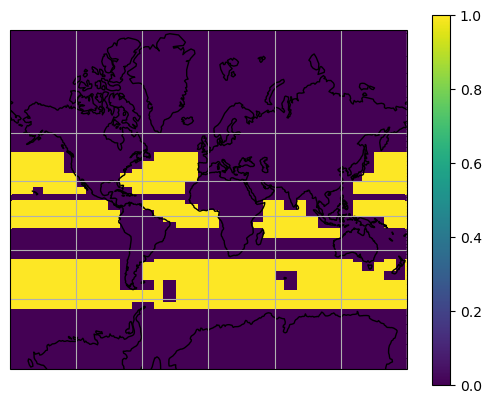

In [6]:
total_mask = sum(interp_mask[d] for d in interp_mask.data_vars)
total_mask.plot.pcolormesh(transform=ccrs.PlateCarree(),subplot_kws={'projection':ccrs.Mercator()})
plt.gca().coastlines()
plt.gca().gridlines()

In [8]:
ocean_expac = ds.where(total_mask).stack(points = ['lat','lon'])
ocean_expac = ocean_expac.dropna('points',how='all')
ocean_expac = ocean_expac[['ucomp','temp','vcomp','height','gwfu_cgwd','gwfv_cgwd','omega']]
ocean_expac = ocean_expac.transpose('time','points','pfull')

In [ ]:
us = ocean_expac.ucomp.values[...,::-1]
zs = ocean_expac.height.values[...,::-1]
temps= ocean_expac.temp.values[...,::-1]
omega = ocean_expac.omega.values[...,::-1] 
gwfu = ocean_expac.gwfu_cgwd.values[...,::-1]
gwfv = ocean_expac.gwfv_cgwd.values[...,::-1]
pfull = ocean_expac.pfull.values[...,::-1]

## determine values needed for ad99


In [10]:

dTdz = np.gradient(temps,axis=-1)/np.gradient(zs,axis=-1)
Ns2 = GRAV/temps*(dTdz + GRAV/C_P) 
bflim = 1e-4 
Ns2 = xr.where(Ns2 < bflim**2,bflim**2,Ns2)
Ns = np.sqrt(Ns2)
rho = (100*pfull.reshape((1,1,-1)))/(R_DRY*temps)

## Obtain true drag/momentum flux PRESCRIBED profiles from MiMA

In [11]:
gwfu_ptv = np.where(gwfu > 0,gwfu,0)
gwfu_ntv = np.where(gwfu < 0,gwfu,0)    
uw_mima_ptv = -1*cumulative_trapezoid(rho[...,::-1]*gwfu_ptv[...,::-1],x=zs[...,::-1],initial=0)[...,::-1]
uw_mima_ntv = -1*cumulative_trapezoid(rho[...,::-1]*gwfu_ntv[...,::-1],x=zs[...,::-1],initial=0)[...,::-1]


gwfv_ptv = np.where(gwfv> 0,gwfv,0)
gwfv_ntv = np.where(gwfv < 0,gwfv,0)
vw_mima_ptv = -1*cumulative_trapezoid(rho[...,::-1]*gwfv_ptv[...,::-1],x=zs[...,::-1],initial=0)[...,::-1]
vw_mima_ntv = -1*cumulative_trapezoid(rho[...,::-1]*gwfv_ntv[...,::-1],x=zs[...,::-1],initial=0)[...,::-1]

## Run AD99 on MiMA u profiles 

In [12]:
from joblib import Parallel, delayed
from tqdm.notebook import tqdm 
gwd = np.zeros_like(us)
uw_total = np.zeros_like(us)
uw_ptv = np.zeros_like(us)
uw_ntv = np.zeros_like(us)

def get_ad99(i,j,ad99):
    gwd = ad99.gwd(us[i,j],Ns[i,j],zs[i,j],rho[i,j])
    uw_total_val = ad99.gwd_momentum_flux(gwd,zs[i,j],rho[i,j])
    uw_ptv = ad99.gwd_momentum_flux_ptv(gwd,zs[i,j],rho[i,j])
    uw_ntv = ad99.gwd_momentum_flux_ntv(gwd,zs[i,j],rho[i,j])
    return i,j,gwd,uw_ptv,uw_ntv,uw_total_val

ad99 = AlexanderDunkerton1999(source_level_height=9e3,damp_top=True,Fs0=4.3e-3)
results = Parallel(n_jobs=-1)(delayed(get_ad99)(i,j,ad99) for i in range(us.shape[0]) for j in range(us.shape[1]))

for i,j,gwd_val,uw_ptv_val,uw_ntv_val,uw_total_val in results:
    gwd[i,j] = gwd_val
    uw_total[i,j] = uw_total_val
    uw_ptv[i,j] = uw_ptv_val
    uw_ntv[i,j] = uw_ntv_val

In [13]:
uw_abs = np.concatenate([np.abs(uw_ntv).reshape(-1,len(pfull)),np.abs(uw_ptv).reshape(-1,len(pfull))])    
uw_total_abs = np.abs(uw_total)

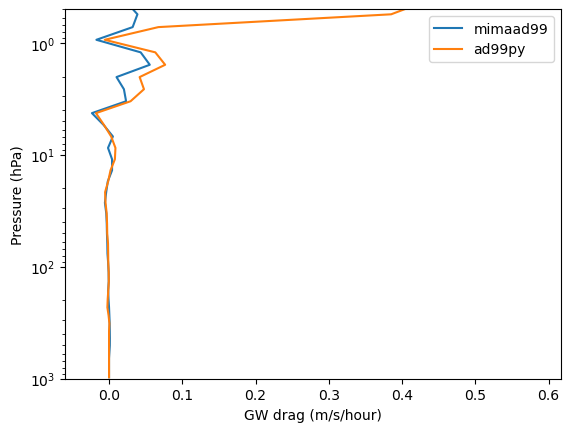

In [14]:
import matplotlib.pyplot as plt 
point = 25
plt.plot(gwfu[0,point]*3600,pfull,label="mimaad99")
plt.plot(gwd[0,point]*3600,pfull,label="ad99py")
plt.yscale('log')
plt.ylabel('Pressure (hPa)')
plt.ylim(0.5,1000)
plt.xlabel('GW drag (m/s/hour)')
plt.gca().invert_yaxis()
plt.legend()

In [15]:
level = 10#hPa
i_level = np.argmin(np.abs(pfull-level))
i_level

np.int64(26)

In [16]:
uw_ptv_mima_lvl = uw_mima_ptv[...,i_level].ravel()  
uw_ptv_mima_lvl = uw_ptv_mima_lvl[uw_ptv_mima_lvl > 0]*1000
uw_ptv_lvl = uw_ptv[...,i_level].ravel()
uw_ptv_lvl = uw_ptv_lvl[uw_ptv_lvl > 0]*1000


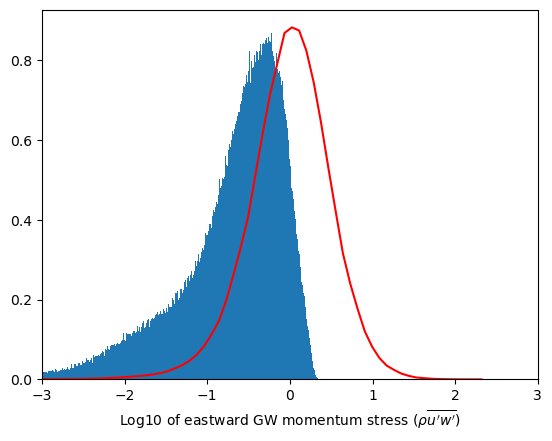

In [17]:

log_loon_ptv_u = np.log10(loon_ptv_u[loon_ptv_u > 0])
loon_bin_heights,loon_bin_edges = np.histogram(log_loon_ptv_u[~np.isnan(log_loon_ptv_u)],bins=100,density=True)
bin_centers = 0.5*(loon_bin_edges[1:] + loon_bin_edges[:-1])
plt.plot(bin_centers,loon_bin_heights,label='Loon',color='r')
plt.hist(np.log10(uw_ptv_mima_lvl),bins=1000,density=True)

plt.xlabel("Log10 of eastward GW momentum stress $(\\rho \\overline{u'w'})$")
plt.xlim(-3,3)
print()

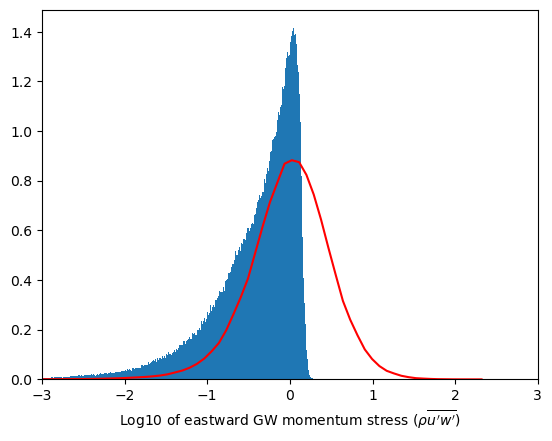

In [18]:

log_loon_ptv_u = np.log10(loon_ptv_u[loon_ptv_u > 0])

loon_bin_heights,loon_bin_edges = np.histogram(log_loon_ptv_u[~np.isnan(log_loon_ptv_u)],bins=100,density=True)
bin_centers = 0.5*(loon_bin_edges[1:] + loon_bin_edges[:-1])
plt.plot(bin_centers,loon_bin_heights,label='Loon',color='r')
plt.hist(np.log10(uw_ptv_lvl),bins=1000,density=True)

plt.xlabel("Log10 of eastward GW momentum stress $(\\rho \\overline{u'w'})$")
plt.xlim(-3,3)
print()

Text(0.5, 0, "Eastward GW momentum stress $(\\rho \\overline{u'w'}) (mPa)$")

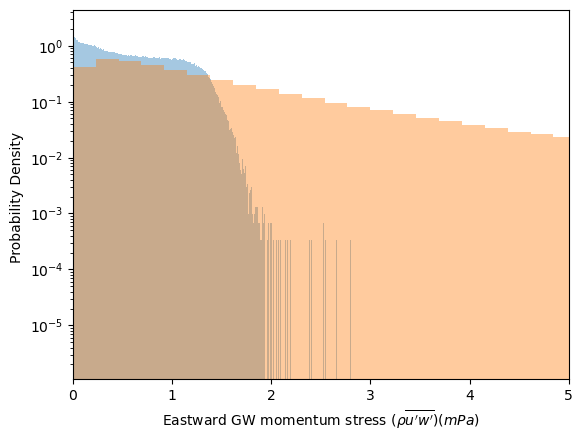

In [19]:
plt.hist(uw_ptv_lvl,density=True,bins=1000,alpha=0.4)
plt.hist(loon_ptv_u[loon_ptv_u > 0],density=True,bins=1000,alpha=0.4)
plt.yscale('log')
plt.xlim(0,5)
plt.ylabel("Probability Density ")
plt.xlabel("Eastward GW momentum stress $(\\rho \\overline{u'w'}) (mPa)$")    

Text(0.5, 0, "Eastward GW momentum stress $(\\rho \\overline{u'w'}) (mPa)$")

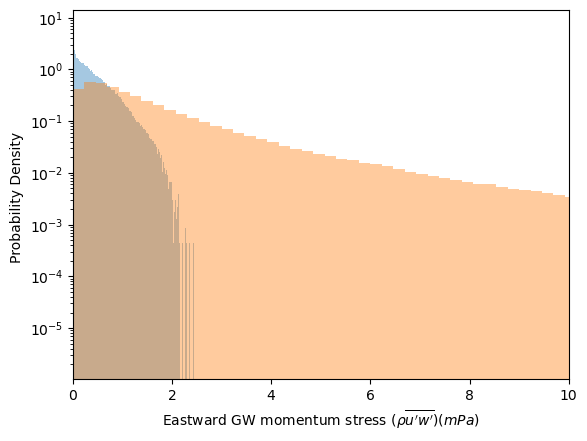

In [20]:
plt.hist(uw_ptv_mima_lvl,density=True,bins=1000,alpha=0.4)
plt.hist(loon_ptv_u[loon_ptv_u > 0],density=True,bins=1000,alpha=0.4)
plt.yscale('log')
plt.xlim(0,10)
plt.ylabel("Probability Density ")
plt.xlabel("Eastward GW momentum stress $(\\rho \\overline{u'w'}) (mPa)$")  

## Determine resolved flux

In [29]:
from resolved_flux import get_resolved_FxFy

Fx_res, Fy_res = get_resolved_FxFy(ds)
Fx_res = Fx_res.where(total_mask).stack(points = ['lat','lon']).dropna('points',how='all')
Fx_res = Fx_res.transpose('time','points','pfull')
Fx_res = Fx_res.values[...,::-1]


In [52]:
uw_w_resolved = uw_total + Fx_res

In [56]:
uw_w_resolved_abs = np.abs(uw_w_resolved)
uw_w_resolved_abs_10hpa = uw_w_resolved_abs[...,i_level].ravel()
uw_w_resolved_abs_10hpa = uw_w_resolved_abs_10hpa[uw_w_resolved_abs_10hpa > 0]*1000 

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

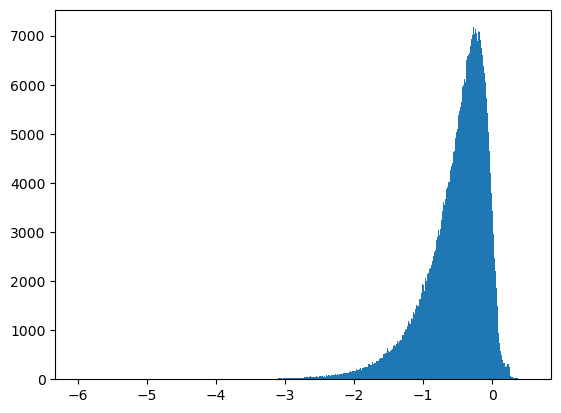

In [55]:
uw_total_abs_10hpa= np.abs(uw_total[...,i_level])
uw_total_abs_10hpa = uw_total_abs_10hpa[uw_total_abs_10hpa>0]*1000
plt.hist(np.log10(uw_total_abs_10hpa),bins=1000)

(-3.0, 3.0)

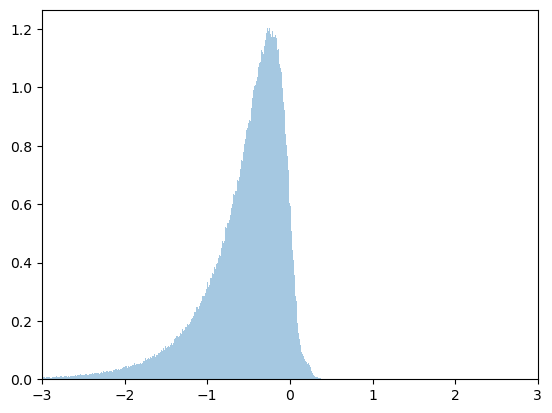

In [57]:
plt.hist(np.log10(uw_w_resolved_abs_10hpa),bins=1000,density=True,alpha=0.4)
plt.xlim(-3,3)

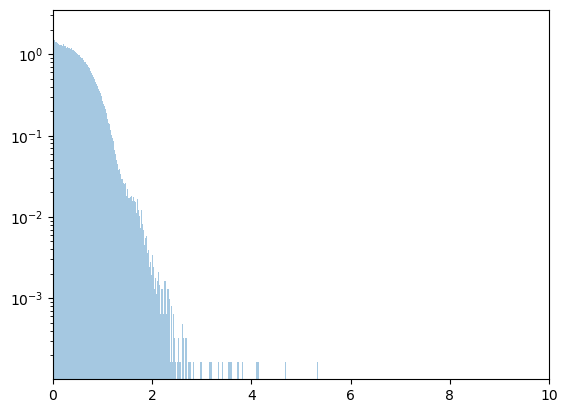

In [58]:
plt.hist(uw_w_resolved_abs_10hpa.ravel(),density=True,bins=1000,alpha=0.4)
plt.xlim(0,10)
plt.yscale('log')

## Calculate AD99py fluxe distr. skew/variance

In [69]:
uw_ptv_lvl = uw_ptv[...,-15]*1000

In [ ]:



vars,skews = variance_and_skew(uw_ptv_lvl)
log_mpa = np.log10(uw_ptv_lvl)
log_mpa[np.isneginf(log_mpa)] = np.nan
log_vars,log_skew = variance_and_skew(log_mpa)

/var/folders/58/1mynp4bn1pg61mc1j6p3nnxc0000gp/T/ipykernel_64937/1840823633.py:11: RuntimeWarning: divide by zero encountered in log10
  log_mpa = np.log10(uw_ptv_lvl)


## Loon fluxes skew/var

In [65]:
extratrop_pacific_fluxes = np.load('/Users/robcking/PhD/loon_GW_mom_flux/extra_pac_flights_flux.npy')
extratrop_pacific_fluxes_ptv = extratrop_pacific_fluxes[1]

var_loon,skew_loon = variance_and_skew(extratrop_pacific_fluxes_ptv)
log_loon = np.log10(extratrop_pacific_fluxes_ptv)
log_loon[np.isneginf(log_loon)] = np.nan
var_log_loon,skew_log_loon = variance_and_skew(log_loon)



/var/folders/58/1mynp4bn1pg61mc1j6p3nnxc0000gp/T/ipykernel_64937/1466978560.py:5: RuntimeWarning: divide by zero encountered in log10
  log_loon = np.log10(extratrop_pacific_fluxes_ptv)


In [71]:
plt.plot(cws,vars)
plt.xlabel('$c_w$ (m/s)')
plt.ylabel("Variance of momentum flux (mPa^2)")
plt.title("Variance of momentum flux with $c_w$")
plt.axhline(var_loon,color='r',label='Loon',linestyle='--')

NameError: name 'cws' is not defined

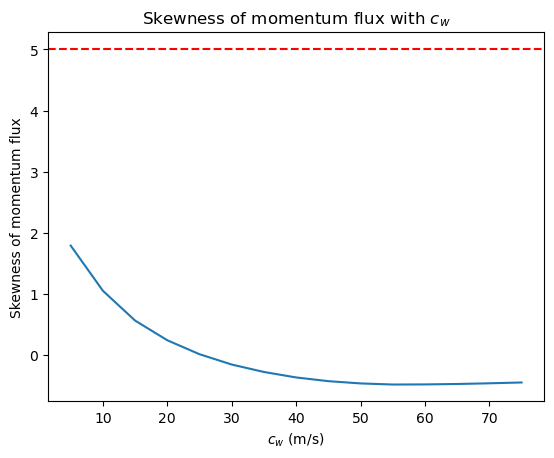

In [83]:
plt.plot(cws,skews)
plt.xlabel('$c_w$ (m/s)')
plt.ylabel("Skewness of momentum flux")
plt.title("Skewness of momentum flux with $c_w$")
plt.axhline(skew_loon,color='r',label='Loon',linestyle='--')    

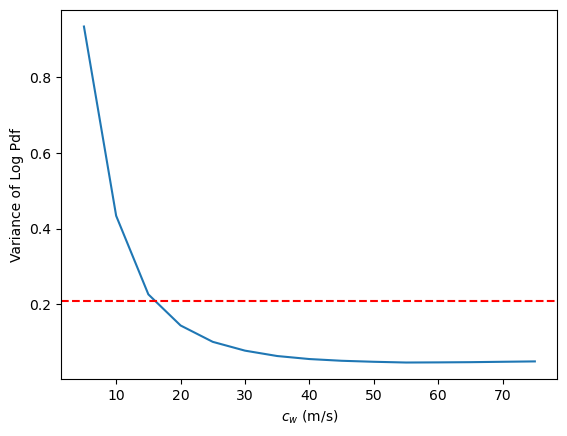

In [84]:
plt.plot(cws,log_vars)
plt.xlabel("$c_w$ (m/s)")
plt.ylabel("Variance of Log Pdf")
plt.axhline(var_log_loon,color='r',label='Loon',linestyle='--') 

Text(0, 0.5, 'Skew of Log Pdf')

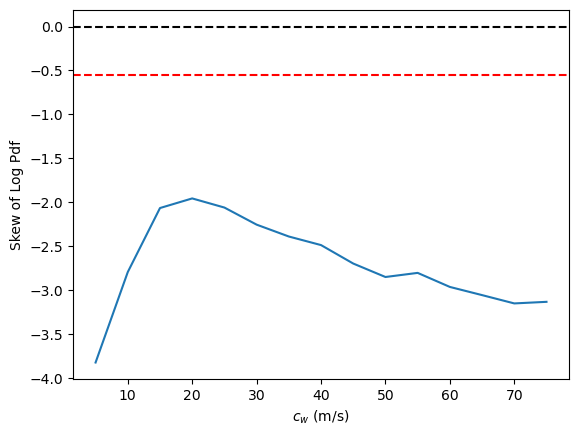

In [86]:
plt.plot(cws,log_skew)
plt.axhline(0,color='k',linestyle='--')
plt.xlabel("$c_w$ (m/s)")
plt.axhline(skew_log_loon,color='r',label='Loon',linestyle='--')
plt.ylabel("Skew of Log Pdf")

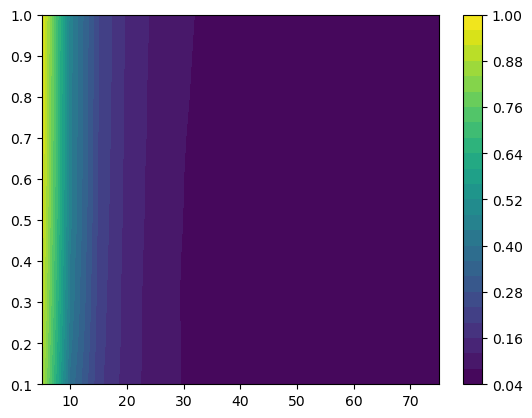

In [123]:
CW, BM = np.meshgrid(cws,bms)

plt.contourf(CW,BM,log_vars,levels=25)
plt.colorbar()

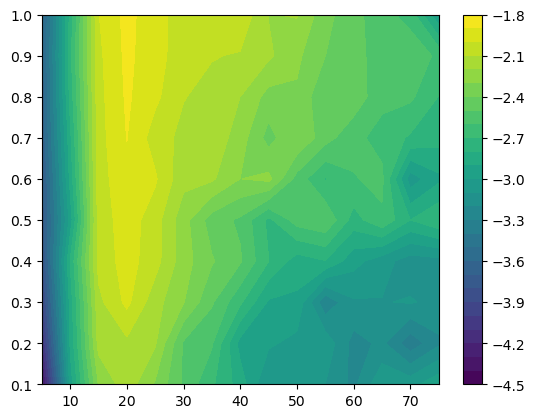

In [124]:
CW, BM = np.meshgrid(cws,bms)

plt.contourf(CW,BM,log_skew,levels=25)
plt.colorbar()

Text(0.5, 1.0, 'Log10 (mPa GW stress) - with source intermittency')

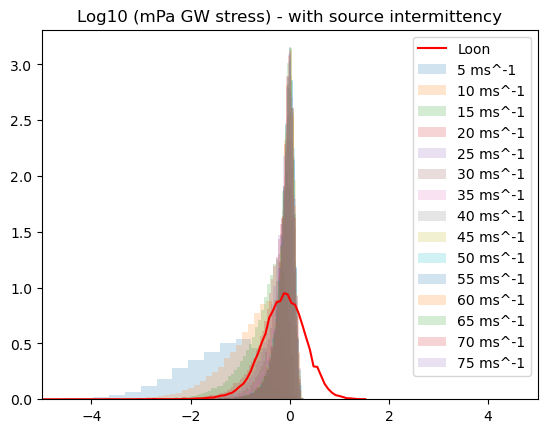

In [93]:
loon_bin_heights,loon_bin_edges = np.histogram(log_loon[~np.isnan(log_loon)],bins=100,density=True)
bin_centers = 0.5*(loon_bin_edges[1:] + loon_bin_edges[:-1])
plt.plot(bin_centers,loon_bin_heights,label='Loon',color='r')
for i,c in enumerate(cws):
    plt.hist(log_mpa[i],bins=100,alpha=0.2,label=f"{c} ms^-1",density=True)
    plt.legend()
plt.xlim(-5,5)
plt.title("Log10 (mPa GW stress) - with source intermittency")

## ERA 5

In [78]:
ds_era5 = xr.open_dataset('data/era52015.grib',engine='cfgrib')

Ignoring index file 'data/era52015.grib.5b7b6.idx' incompatible with GRIB file


In [79]:
ds_era5 = ds_era5.stack(points = ['latitude','longitude'])
ds_era5 = ds_era5.transpose('time','points','isobaricInhPa')


In [80]:
ds_era5

<xarray.Dataset> Size: 3GB
Dimensions:        (time: 365, isobaricInhPa: 21, points: 32421)
Coordinates:
    number         int64 8B ...
  * time           (time) datetime64[ns] 3kB 2015-01-01T12:00:00 ... 2015-12-...
    step           timedelta64[ns] 8B ...
  * isobaricInhPa  (isobaricInhPa) float64 168B 450.0 400.0 350.0 ... 2.0 1.0
    valid_time     (time) datetime64[ns] 3kB ...
  * points         (points) object 259kB MultiIndex
  * latitude       (points) float64 259kB 15.0 15.0 15.0 ... -10.0 -10.0 -10.0
  * longitude      (points) float64 259kB -180.0 -179.8 -179.5 ... -100.2 -100.0
Data variables:
    z              (time, points, isobaricInhPa) float32 994MB 6.582e+04 ... ...
    t              (time, points, isobaricInhPa) float32 994MB 264.9 ... 260.4
    u              (time, points, isobaricInhPa) float32 994MB -8.308 ... -67.78
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-03-09T19:45 GRIB to CDM+CF via cfgrib-0.9.1...

In [81]:
era_u = ds_era5.u.values
era_z = ds_era5.z.values/GRAV
era_temp = ds_era5.t.values
era_p = ds_era5.isobaricInhPa*100

era_dTdz = np.gradient(era_temp,axis=-1)/np.gradient(era_z,axis=-1)
era_Ns2 = GRAV/era_temp*(era_dTdz + GRAV/C_P) 
bflim = 1e-4 
era_Ns2 = xr.where(era_Ns2 < bflim**2,bflim**2,era_Ns2)
era_Ns = np.sqrt(era_Ns2)
era_rho = (era_p.values.reshape((1,1,-1)))/(R_DRY*era_temp)

In [67]:
from joblib import Parallel, delayed

era5_gwd = np.zeros_like(era_u)
era5_uw_ptv = np.zeros_like(era_u)
era5_uw_ntv = np.zeros_like(era_u)

def get_ad99(i,j,ad99:AlexanderDunkerton1999):
    gwd = ad99.gwd(era_u[i,j],era_Ns[i,j],era_z[i,j],era_rho[i,j])
    uw_ptv = ad99.gwd_momentum_flux_ptv(gwd,era_z[i,j],era_rho[i,j])    
    uw_ntv = ad99.gwd_momentum_flux_ntv(gwd,era_z[i,j],era_rho[i,j])    
    return i,j,gwd,uw_ptv,uw_ntv

ad99 = AlexanderDunkerton1999(source_level_height=9e3,damp_top=True,base_wavelength=30e3) # smaller grid, smaller wavelength
results = Parallel(n_jobs=-1)(delayed(get_ad99)(i,j,ad99) for i in range(era_u.shape[0]) for j in range(era_u.shape[1]))

for i,j,era_gwd_val,era_uw_ptv_val,era_uw_ntv_val in results:
    era5_gwd[i,j] = era_gwd_val
    era5_uw_ptv[i,j] = era_uw_ptv_val
    era5_uw_ntv[i,j] = era_uw_ntv_val

In [68]:
np.save('era5_gwd.npy',era5_gwd)
np.save('era5_uw_ptv.npy',era5_uw_ptv)
np.save('era5_uw_ntv.npy',era5_uw_ntv)  

In [76]:
import os 
if os.path.exists("data/era5_gwd.npy"):
    era5_gwd = np.load("data/era5_gwd.npy")
if os.path.exists("data/era5_uw_ntv.npy"):
    era5_uw_ntv = np.load("data/era5_uw_ntv.npy")
if os.path.exists("data/era5_uw_ptv.npy"):
    era5_uw_ptv = np.load("data/era5_uw_ptv.npy")


In [83]:
era5_uw_ptv_lvl = era5_uw_ptv[...,int(np.argmin(np.abs(ds_era5.isobaricInhPa.values - 10)))].ravel()
era5_uw_ptv_lvl = era5_uw_ptv_lvl[era5_uw_ptv_lvl > 0]
era5_uw_ntv_lvl = era5_uw_ntv[...,int(np.argmin(np.abs(ds_era5.isobaricInhPa.values - 10)))].ravel()
era5_uw_ntv_lvl = -1*era5_uw_ntv_lvl[era5_uw_ntv_lvl < 0]

(array([1.72153865e+00, 2.02393892e+00, 1.88713701e+00, 1.71491919e+00,
        1.61339919e+00, 1.53842729e+00, 1.46502637e+00, 1.41079751e+00,
        1.35091326e+00, 1.33278592e+00, 1.31371744e+00, 1.30095286e+00,
        1.29327173e+00, 1.27415630e+00, 1.27147764e+00, 1.26019682e+00,
        1.24377609e+00, 1.23518465e+00, 1.22418952e+00, 1.20871747e+00,
        1.19929460e+00, 1.18653872e+00, 1.17542298e+00, 1.15810686e+00,
        1.14365277e+00, 1.12218483e+00, 1.09033468e+00, 1.07468497e+00,
        1.05115797e+00, 1.02472999e+00, 1.00236469e+00, 9.70186165e-01,
        9.37845738e-01, 9.09132498e-01, 8.76250761e-01, 8.43987747e-01,
        8.15449906e-01, 7.78587171e-01, 7.37215705e-01, 7.09075057e-01,
        6.67964209e-01, 6.34139921e-01, 5.96850210e-01, 5.60654454e-01,
        5.22069386e-01, 4.77127893e-01, 4.36265326e-01, 3.96747151e-01,
        3.60546729e-01, 3.24812380e-01, 2.90973240e-01, 2.57785395e-01,
        2.28659516e-01, 2.00224978e-01, 1.74397983e-01, 1.524609

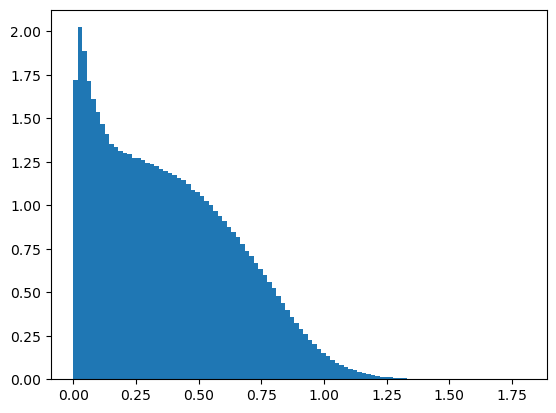

In [84]:
plt.hist(era5_uw_ptv_lvl*1000,bins=100,density=True)


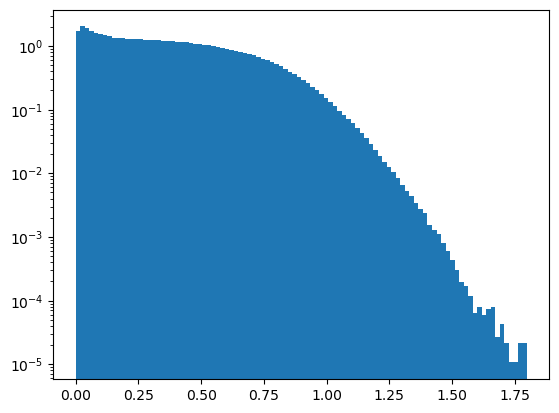

In [85]:
import matplotlib.pyplot as plt
plt.hist(era5_uw_ptv_lvl*1000,bins=100,density=True)
plt.yscale("log")

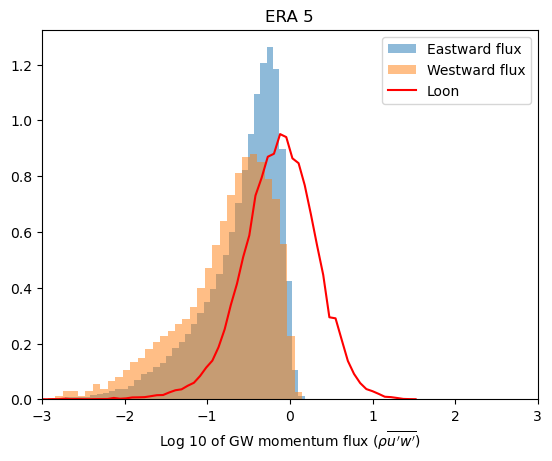

In [88]:
plt.hist(np.log10(1000*era5_uw_ptv_lvl),bins=100,density=True,alpha=0.5,label='Eastward flux')
plt.hist(np.log10(1000*era5_uw_ntv_lvl),bins=100,density=True,alpha=0.5,label='Westward flux')
plt.plot(bin_centers,loon_bin_heights,label='Loon',color='r')
plt.xlabel("Log 10 of GW momentum flux $(\\rho\\overline{u'w'})$")
plt.title("ERA 5")
plt.xlim(-3,3)
plt.legend()

(array([1.000000e+00, 0.000000e+00, 0.000000e+00, 2.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        2.000000e+00, 0.000000e+00, 0.000000e+00, 3.000000e+00,
        2.000000e+00, 3.000000e+00, 1.000000e+00, 0.000000e+00,
        1.000000e+00, 2.000000e+00, 5.000000e+00, 1.000000e+00,
        3.000000e+00, 7.000000e+00, 6.000000e+00, 7.000000e+00,
        1.200000e+01, 1.100000e+01, 1.500000e+01, 2.100000e+01,
        1.900000e+01, 2.600000e+01, 2.900000e+01, 2.900000e+01,
        2.900000e+01, 4.800000e+01, 5.300000e+01, 6.500000e+01,
        5.900000e+01, 7.700000e+01, 9.800000e+01, 8.800000e+01,
        1.180000e+02, 1.490000e+02, 1.900000e+02, 1.970000e+02,
        2.330000e+02, 3.020000e+02, 3.000000e+02, 3.730000e+02,
        4.450000e+02, 4.990000e+02, 6.080000e+02, 6.640000e+02,
        7.750000e+02, 9.240000e+02, 1.063000e+03, 1.222000e+03,
        1.505000e+03, 1.778000e+03, 2.395000e+03, 3.164000e+03,
        4.172000e+03, 5.729000e+03, 5.52

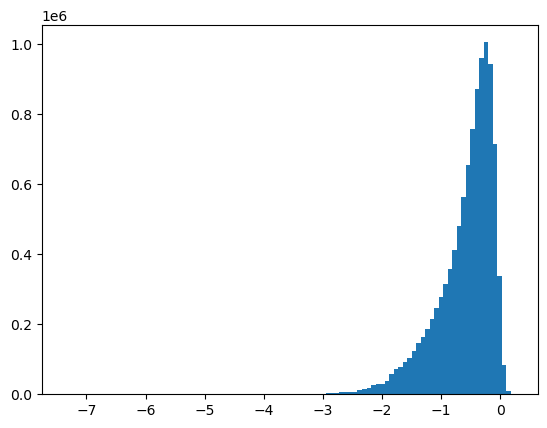

In [35]:
plt.hist(np.log10(1000*era5_uw_ptv_lvl),bins=100)